In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score

import glob
import cv2
from PIL import Image
import os
import random
from tqdm import tqdm

torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
for root, dirs, files in os.walk('data/crop_part1'):
    print(f"The Root Folder is {root}")
    print(f"The Subfolders are {dirs}")
    print(f"The nbr of Files are {len(files)}")

The Root Folder is data/crop_part1
The Subfolders are []
The nbr of Files are 9779


In [3]:
images = []
ages = []
genders = []
male_count = 0

for i in os.listdir('data/crop_part1'):
    try:
        file_path = os.path.join('data/crop_part1', i)
        split = i.split('_')
        
        ages.append(int(split[0]))
        
        g = int(split[1])
        if g not in [0, 1]:
            print(f"Invalid gender label {g} in file {i}. Skipping.")
            continue
        genders.append(g)

        if split[1] == '0':
            male_count += 1
        
        img = Image.open(file_path).resize((128, 128))
        images.append(np.array(img))
        
    except Exception as e:
        print(f"We have an error in {i} {e}")

images = np.array(images) / 255.0
genders = np.array(genders)
ages = np.array(ages)

print(f"Images Shape: {images.shape}")
print(f"Genders Shape: {genders.shape}")
print(f"Ages Shape: {ages.shape}")

Images Shape: (9779, 128, 128, 3)
Genders Shape: (9779,)
Ages Shape: (9779,)


In [4]:
female_count = len(images) - male_count

In [5]:
female_count, male_count

(5407, 4372)

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
gender_values = np.array([female_count, male_count])
gender_labels = ["Male", "Female"]

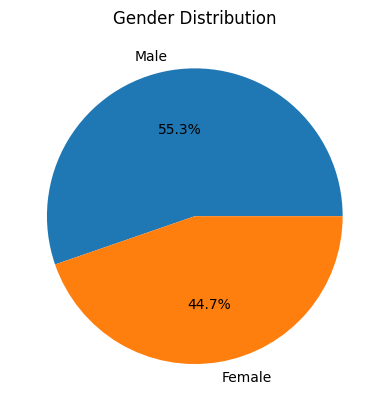

In [7]:
plt.pie(gender_values, labels=gender_labels, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

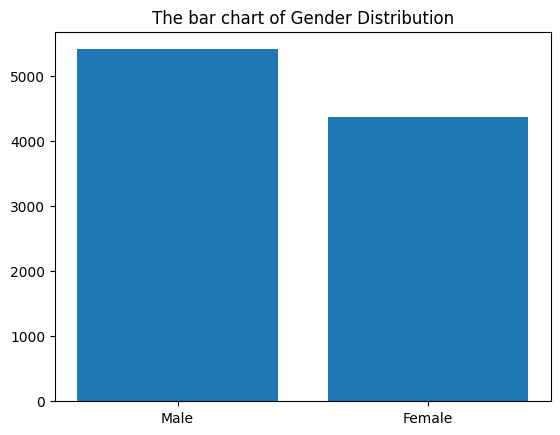

In [8]:
plt.bar(gender_labels, gender_values)
plt.title('The bar chart of Gender Distribution')
plt.show()

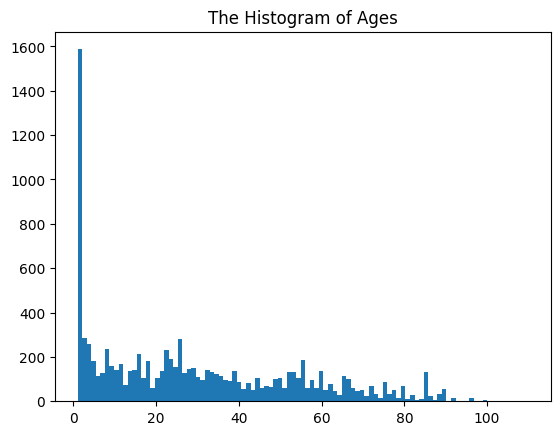

In [9]:
plt.hist(sorted(ages), bins=len(set(ages)))
plt.title('The Histogram of Ages')
plt.show()

In [10]:
images.shape

(9779, 128, 128, 3)

In [11]:
gender_labels

['Male', 'Female']

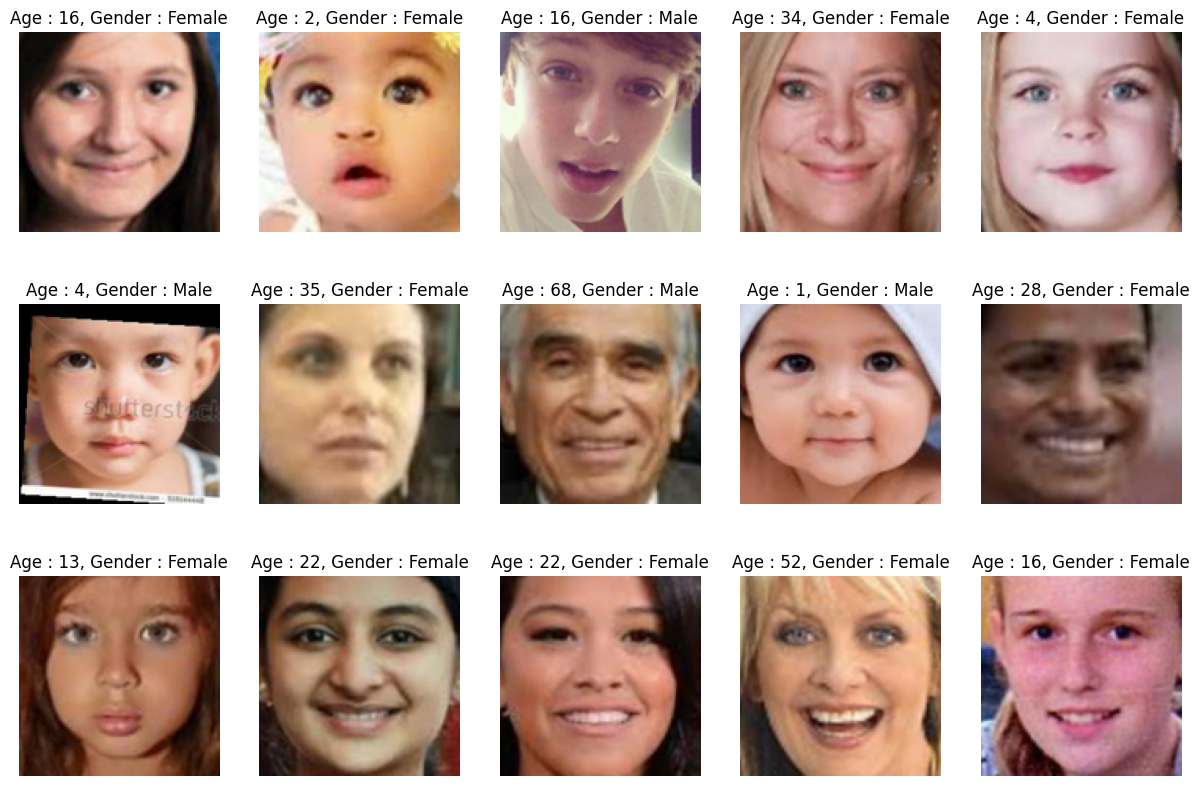

In [12]:
num_images = 15 
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()
random_choince_images = random.choices(range(len(images)), k=num_images)
for i, ax in enumerate(random_choince_images):
    axes[i].imshow(images[ax])
    axes[i].axis('off')

    age = ages[ax]
    axes[i].set_title(f"Age : {age}, Gender : {gender_labels[genders[ax]]}")


In [13]:
len(images), len(ages), len(genders)

(9779, 9779, 9779)

In [14]:
X_train, X_temp, y_train_age, y_temp_age, y_train_gender, y_temp_gender = train_test_split(images, ages, genders, test_size=0.2, random_state=42)
X_val, X_test, y_val_age, y_test_age, y_val_gender, y_test_gender = train_test_split(X_temp, y_temp_age, y_temp_gender, test_size=0.5, random_state=42)

print(f"Train set : {X_train.shape}")
print(f"Validation set : {X_val.shape}, Age labels : {len(y_val_age)} and Gender labels : {len(y_val_gender)}")
print(f"Test set : {X_test.shape}, Age labels : {len(y_test_age)} and Gender labels : {len(y_test_gender)}")

Train set : (7823, 128, 128, 3)
Validation set : (978, 128, 128, 3), Age labels : 978 and Gender labels : 978
Test set : (978, 128, 128, 3), Age labels : 978 and Gender labels : 978


In [15]:
class MultiTaskDataset(Dataset):
    def __init__(self, images, ages, genders):
        # Convert images to tensor
        self.images = torch.tensor(images, dtype=torch.float32)
        # Permute to (N, C, H, W)
        self.images = self.images.permute(0, 3, 1, 2)
        
        self.ages = torch.tensor(ages, dtype=torch.float32)
        self.genders = torch.tensor(genders, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.ages[idx], self.genders[idx]

In [16]:
train_dataset = MultiTaskDataset(X_train, y_train_age, y_train_gender)
val_dataset = MultiTaskDataset(X_val, y_val_age, y_val_gender)
test_dataset = MultiTaskDataset(X_test, y_test_age, y_test_gender)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
len(train_loader), len(val_loader), len(test_loader)

(245, 31, 31)

In [ ]:
class ResNet50MultiTask(nn.Module):
    """
    ResNet50 multi-task model for age and gender prediction.
    Expects input images of size 128x128 pixels.
    Input tensor shape: (batch_size, 3, 128, 128)
    """
    def __init__(self, pretrained=True, dropout_rate=0.5):
        super(ResNet50MultiTask, self).__init__()
        
        self.resnet50 = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Identity()  # Remove the final fully connected layer
        
        self.dropout = nn.Dropout(dropout_rate)
        self.feature_bn = nn.BatchNorm1d(num_features)
        
        # Age specific layers
        self.age_fc1 = nn.Linear(num_features, 512)
        self.age_bn1 = nn.BatchNorm1d(512)
        self.age_fc2 = nn.Linear(512, 256)
        self.age_bn2 = nn.BatchNorm1d(256)
        self.age_output = nn.Linear(256, 1)
        
        # Gender specific layers
        self.gender_fc1 = nn.Linear(num_features, 512)
        self.gender_bn1 = nn.BatchNorm1d(512)
        self.gender_fc2 = nn.Linear(512, 256)
        self.gender_bn2 = nn.BatchNorm1d(256)
        self.gender_output = nn.Linear(256, 1)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in [self.age_fc1, self.age_fc2, self.age_output,
                 self.gender_fc1, self.gender_fc2, self.gender_output]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if x.shape[-2:] != (128, 128):
            raise ValueError(f"Expected input images of shape (batch_size, 3, 128, 128), "
                           f"but got {x.shape}")
        
        # ResNet feature extraction
        x = self.resnet50(x)
        x = self.feature_bn(x)
        x = self.dropout(x)
        
        # Age branch
        age = F.relu(self.age_bn1(self.age_fc1(x)))
        age = self.dropout(age)
        age = F.relu(self.age_bn2(self.age_fc2(age)))
        age = self.dropout(age)
        age = self.age_output(age)
        
        # Gender branch
        gender = F.relu(self.gender_bn1(self.gender_fc1(x)))
        gender = self.dropout(gender)
        gender = F.relu(self.gender_bn2(self.gender_fc2(gender)))
        gender = self.dropout(gender)
        gender = torch.sigmoid(self.gender_output(gender))
        
        return age, gender

    def get_trainable_parameters(self):
        """Returns the number of trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def test_model_dummy():
    # Create model
    model = ResNet50MultiTask(pretrained=True)
    
    batch_size = 4
    dummy_input = torch.randn(batch_size, 3, 128, 128)  # Correct size for your use case
    age_pred, gender_pred = model(dummy_input)
    
    print(f"Model trainable parameters: {model.get_trainable_parameters():,}")
    print(f"Input shape: {dummy_input.shape}")
    print(f"Age output shape: {age_pred.shape}")
    print(f"Gender output shape: {gender_pred.shape}")
    
    return model

test_model_dummy()

Model trainable parameters: 25,876,546
Input shape: torch.Size([4, 3, 128, 128])
Age output shape: torch.Size([4, 1])
Gender output shape: torch.Size([4, 1])


ResNet50MultiTask(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [20]:
model = ResNet50MultiTask(pretrained=True)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
age_criterion = nn.MSELoss()
gender_criterion = nn.BCELoss()

c:\Users\PREDATOR\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_epoch(optimizer, model, train_loader, age_criterion, gender_criterion, device):
    model.train()
    total_loss = 0.0
    age_predictions = []
    age_targets = []
    gender_predictions = []
    gender_targets = []
    
    for batch in tqdm(train_loader, desc='Training'):
        images, ages, genders = [x.to(device) for x in batch]
        
        optimizer.zero_grad()
        age_pred, gender_pred = model(images)
        
        age_loss = age_criterion(age_pred.squeeze(), ages.float())
        gender_loss = gender_criterion(gender_pred.squeeze(), genders.float())
        loss = age_loss + gender_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        age_predictions.extend(age_pred.squeeze().detach().cpu().numpy())
        age_targets.extend(ages.cpu().numpy())
        gender_predictions.extend((gender_pred.squeeze() > 0.5).detach().cpu().numpy())
        gender_targets.extend(genders.cpu().numpy())
    
    metrics = {
        'total_loss': total_loss / len(train_loader),
        'age_mae': mean_absolute_error(age_targets, age_predictions),
        'gender_acc': accuracy_score(gender_targets, gender_predictions)
    }
    return metrics

def val_epoch(model, val_loader, age_criterion, gender_criterion, device):
    model.eval()
    total_loss = 0.0
    age_predictions = []
    age_targets = []
    gender_predictions = []  
    gender_targets = []      
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            images, ages, genders = [x.to(device) for x in batch]  
            
            age_pred, gender_pred = model(images)
            
            age_loss = age_criterion(age_pred.squeeze(), ages.float())
            gender_loss = gender_criterion(gender_pred.squeeze(), genders.float())
            loss = age_loss + gender_loss
            
            total_loss += loss.item()
            
            age_predictions.extend(age_pred.squeeze().cpu().numpy())
            age_targets.extend(ages.cpu().numpy())
            gender_predictions.extend((gender_pred.squeeze() > 0.5).cpu().numpy())
            gender_targets.extend(genders.cpu().numpy())
    
    metrics = {
        'total_loss': total_loss / len(val_loader),
        'age_mae': mean_absolute_error(age_targets, age_predictions),
        'gender_acc': accuracy_score(gender_targets, gender_predictions)  # Fixed: Corrected variable names
    }
    return metrics

In [ ]:
def train_model(num_epochs, model, train_loader, val_loader, optimizer, device):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_age_mae': [], 'val_age_mae': [],
        'train_gender_acc': [], 'val_gender_acc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch(
            optimizer=optimizer,
            model=model,
            train_loader=train_loader,
            age_criterion=age_criterion,
            gender_criterion=gender_criterion,
            device=device
        )
        
        val_metrics = val_epoch(
            model=model,
            val_loader=val_loader,
            age_criterion=age_criterion,
            gender_criterion=gender_criterion,
            device=device
        )
        
        scheduler.step(val_metrics['total_loss'])
        
        if val_metrics['total_loss'] < best_val_loss:
            best_val_loss = val_metrics['total_loss']
            torch.save(model.state_dict(), 'Models/best_model.pth')
        
        history['train_loss'].append(train_metrics['total_loss'])
        history['val_loss'].append(val_metrics['total_loss'])
        history['train_age_mae'].append(train_metrics['age_mae'])
        history['val_age_mae'].append(val_metrics['age_mae'])
        history['train_gender_acc'].append(train_metrics['gender_acc'])
        history['val_gender_acc'].append(val_metrics['gender_acc'])
        
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_metrics['total_loss']:.4f}, Val Loss: {val_metrics['total_loss']:.4f}")
        print(f"Train Age MAE: {train_metrics['age_mae']:.2f}, Val Age MAE: {val_metrics['age_mae']:.2f}")
        print(f"Train Gender Acc: {train_metrics['gender_acc']*100:.2f}%, Val Gender Acc: {val_metrics['gender_acc']*100:.2f}%")
    
    return history

def test_model(model, test_loader, device):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    
    age_predictions = []
    age_targets = []
    gender_predictions = []
    gender_targets = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            images, ages, genders = [x.to(device) for x in batch]
            
            age_pred, gender_pred = model(images)
            
            age_predictions.extend(age_pred.squeeze().cpu().numpy())
            age_targets.extend(ages.cpu().numpy())
            gender_predictions.extend((gender_pred.squeeze() > 0.5).cpu().numpy())
            gender_targets.extend(genders.cpu().numpy())
    
    metrics = {
        'age_mae': mean_absolute_error(age_targets, age_predictions),
        'gender_acc': accuracy_score(gender_targets, gender_predictions)
    }
    
    print("\nTest Results:")
    print(f"Age MAE: {metrics['age_mae']:.2f}")
    print(f"Gender Accuracy: {metrics['gender_acc']*100:.2f}%")
    
    return metrics

In [24]:
def plot_training_history(history):
    os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 8))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title("Total Loss")
    ax1.legend()

    ax2.plot(history['train_age_mae'], label='Train Age MAE')
    ax2.plot(history['val_age_mae'], label='Validation Age MAE')
    ax2.set_title("Age MAE")
    ax2.legend()

    ax3.plot(history['train_gender_acc'], label='Train')
    ax3.plot(history['val_gender_acc'], label='Validation') 
    ax3.set_title('Gender Accuracy')
    ax3.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_evaluate_model(model, train_loader, val_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    history = train_model(
        num_epochs=20,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device
    )
    
    test_metrics = test_model(
        model=model,
        test_loader=test_loader,
        device=device
    )
    
    plot_training_history(history)
    
    return history, test_metrics

Using device: cuda


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.15it/s]



Epoch 1/30
Train Loss: 574.3508, Val Loss: 242.9980
Train Age MAE: 17.58, Val Age MAE: 11.90
Train Gender Acc: 57.87%, Val Gender Acc: 58.28%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.46it/s]



Epoch 2/30
Train Loss: 125.9343, Val Loss: 104.4751
Train Age MAE: 7.71, Val Age MAE: 6.84
Train Gender Acc: 61.08%, Val Gender Acc: 62.47%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.54it/s]



Epoch 3/30
Train Loss: 90.8028, Val Loss: 107.8884
Train Age MAE: 6.59, Val Age MAE: 6.92
Train Gender Acc: 64.89%, Val Gender Acc: 66.97%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.77it/s]



Epoch 4/30
Train Loss: 83.3145, Val Loss: 81.0750
Train Age MAE: 6.34, Val Age MAE: 6.26
Train Gender Acc: 66.68%, Val Gender Acc: 67.79%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.24it/s]



Epoch 5/30
Train Loss: 83.0767, Val Loss: 74.0138
Train Age MAE: 6.30, Val Age MAE: 5.95
Train Gender Acc: 65.93%, Val Gender Acc: 69.43%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.68it/s]



Epoch 6/30
Train Loss: 92.5000, Val Loss: 97.3317
Train Age MAE: 6.73, Val Age MAE: 6.85
Train Gender Acc: 66.97%, Val Gender Acc: 67.79%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.83it/s]



Epoch 7/30
Train Loss: 81.9959, Val Loss: 109.5930
Train Age MAE: 6.37, Val Age MAE: 7.29
Train Gender Acc: 67.21%, Val Gender Acc: 68.81%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.88it/s]



Epoch 8/30
Train Loss: 73.6568, Val Loss: 115.0127
Train Age MAE: 6.06, Val Age MAE: 8.05
Train Gender Acc: 68.22%, Val Gender Acc: 62.37%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.14it/s]



Epoch 9/30
Train Loss: 87.1895, Val Loss: 92.7782
Train Age MAE: 6.47, Val Age MAE: 6.42
Train Gender Acc: 67.33%, Val Gender Acc: 69.02%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.16it/s]



Epoch 10/30
Train Loss: 64.1714, Val Loss: 67.0106
Train Age MAE: 5.67, Val Age MAE: 5.70
Train Gender Acc: 68.46%, Val Gender Acc: 71.78%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.85it/s]



Epoch 11/30
Train Loss: 62.7064, Val Loss: 76.1310
Train Age MAE: 5.60, Val Age MAE: 6.10
Train Gender Acc: 69.88%, Val Gender Acc: 75.66%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.17it/s]



Epoch 12/30
Train Loss: 55.2697, Val Loss: 69.6102
Train Age MAE: 5.26, Val Age MAE: 5.44
Train Gender Acc: 70.57%, Val Gender Acc: 75.46%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.18it/s]



Epoch 13/30
Train Loss: 54.9386, Val Loss: 98.6860
Train Age MAE: 5.28, Val Age MAE: 6.57
Train Gender Acc: 71.52%, Val Gender Acc: 68.10%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.94it/s]



Epoch 14/30
Train Loss: 70.4840, Val Loss: 114.6384
Train Age MAE: 5.91, Val Age MAE: 6.81
Train Gender Acc: 69.83%, Val Gender Acc: 69.53%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.11it/s]



Epoch 15/30
Train Loss: 65.3432, Val Loss: 72.5605
Train Age MAE: 5.66, Val Age MAE: 5.51
Train Gender Acc: 71.83%, Val Gender Acc: 75.56%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.01it/s]



Epoch 16/30
Train Loss: 143.2567, Val Loss: 100.8902
Train Age MAE: 8.16, Val Age MAE: 6.80
Train Gender Acc: 64.76%, Val Gender Acc: 65.44%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.72it/s]



Epoch 17/30
Train Loss: 78.9278, Val Loss: 78.9957
Train Age MAE: 6.20, Val Age MAE: 5.84
Train Gender Acc: 65.70%, Val Gender Acc: 68.81%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.85it/s]



Epoch 18/30
Train Loss: 70.2791, Val Loss: 73.2300
Train Age MAE: 5.92, Val Age MAE: 5.67
Train Gender Acc: 67.90%, Val Gender Acc: 69.84%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.68it/s]



Epoch 19/30
Train Loss: 61.1136, Val Loss: 74.9673
Train Age MAE: 5.59, Val Age MAE: 5.69
Train Gender Acc: 69.27%, Val Gender Acc: 71.37%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.43it/s]



Epoch 20/30
Train Loss: 55.6564, Val Loss: 77.0288
Train Age MAE: 5.30, Val Age MAE: 5.67
Train Gender Acc: 69.22%, Val Gender Acc: 71.27%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.66it/s]



Epoch 21/30
Train Loss: 51.2180, Val Loss: 69.4088
Train Age MAE: 5.15, Val Age MAE: 5.37
Train Gender Acc: 70.27%, Val Gender Acc: 71.27%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.79it/s]



Epoch 22/30
Train Loss: 45.0341, Val Loss: 70.4650
Train Age MAE: 4.81, Val Age MAE: 5.43
Train Gender Acc: 70.78%, Val Gender Acc: 71.78%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.33it/s]



Epoch 23/30
Train Loss: 45.4814, Val Loss: 66.6108
Train Age MAE: 4.76, Val Age MAE: 5.29
Train Gender Acc: 70.79%, Val Gender Acc: 71.98%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.48it/s]



Epoch 24/30
Train Loss: 44.8495, Val Loss: 66.1398
Train Age MAE: 4.78, Val Age MAE: 5.27
Train Gender Acc: 71.72%, Val Gender Acc: 72.80%


Validation: 100%|██████████| 31/31 [00:01<00:00, 17.24it/s]



Epoch 25/30
Train Loss: 44.5899, Val Loss: 72.3821
Train Age MAE: 4.78, Val Age MAE: 5.54
Train Gender Acc: 71.57%, Val Gender Acc: 74.03%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.90it/s]



Epoch 26/30
Train Loss: 43.8076, Val Loss: 70.6935
Train Age MAE: 4.71, Val Age MAE: 5.43
Train Gender Acc: 71.14%, Val Gender Acc: 71.78%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.63it/s]



Epoch 27/30
Train Loss: 42.6169, Val Loss: 64.6184
Train Age MAE: 4.67, Val Age MAE: 5.32
Train Gender Acc: 70.97%, Val Gender Acc: 74.74%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.99it/s]



Epoch 28/30
Train Loss: 42.2504, Val Loss: 63.9171
Train Age MAE: 4.62, Val Age MAE: 5.30
Train Gender Acc: 71.24%, Val Gender Acc: 74.64%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.42it/s]



Epoch 29/30
Train Loss: 40.6414, Val Loss: 64.0635
Train Age MAE: 4.61, Val Age MAE: 5.21
Train Gender Acc: 71.93%, Val Gender Acc: 73.93%


Validation: 100%|██████████| 31/31 [00:01<00:00, 16.89it/s]
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_13776\1538302089.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature


Epoch 30/30
Train Loss: 41.4176, Val Loss: 65.2035
Train Age MAE: 4.62, Val Age MAE: 5.24
Train Gender Acc: 71.97%, Val Gender Acc: 74.23%


Testing: 100%|██████████| 31/31 [00:01<00:00, 16.56it/s]



Test Results:
Age MAE: 4.53
Gender Accuracy: 78.32%


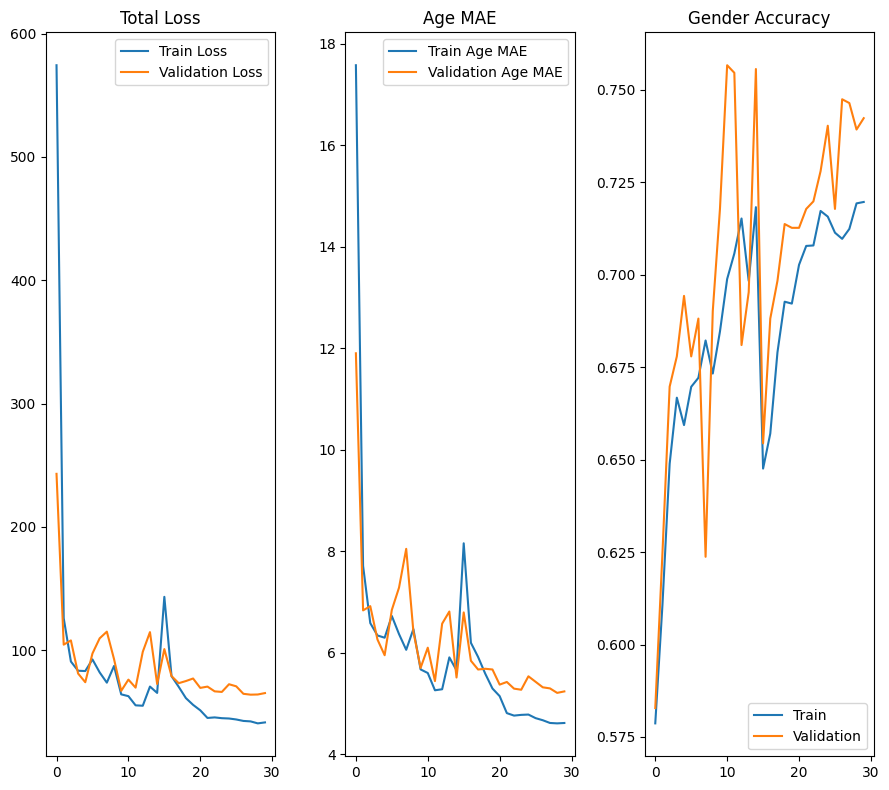

In [26]:
history, test_metrics = train_and_evaluate_model(model, train_loader, val_loader, test_loader)

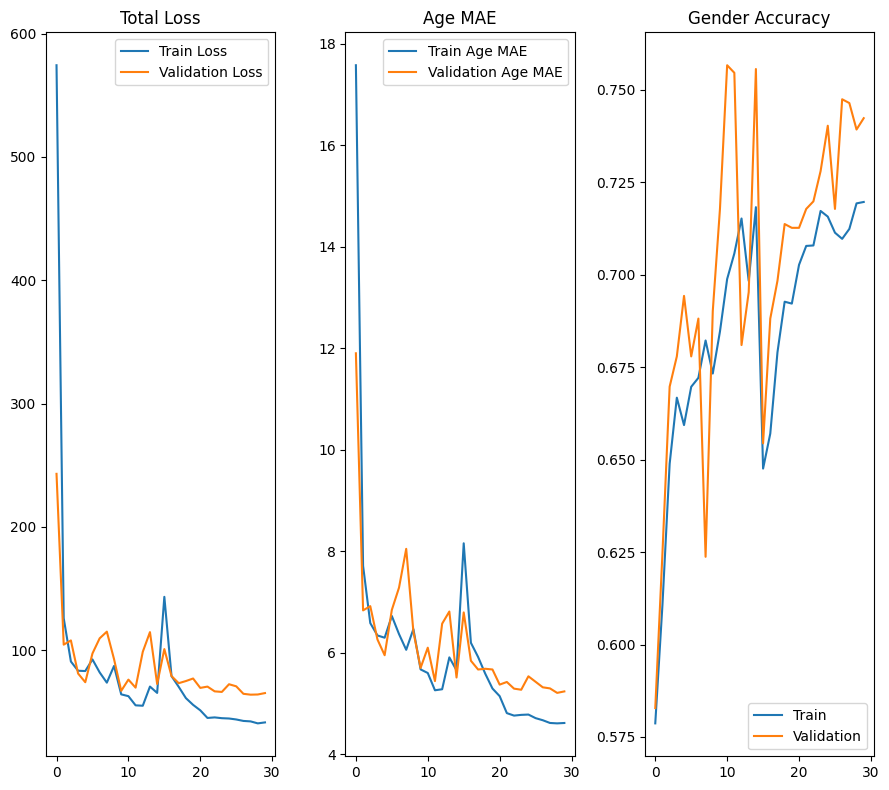

In [27]:
plot_training_history(history)

In [30]:
image_path = 'data/UTKFace/1_0_0_20161219140623097.jpg.chip.jpg'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_prediction(image_path, device, model_path='best_model.pth'):
    model = ResNet50MultiTask(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        age_pred, gender_pred = model(input_tensor)
        
        predicted_age = age_pred.item()
        predicted_gender = 1 if gender_pred.item() > 0.5 else 0
        
        return predicted_age, predicted_gender, image
    
predected_age, predected_gender, image = make_prediction(image_path, device)

print(f"Predicted Age: {predected_age:.1} and the Actual Age : {image_path.split('/')[-1].split('_')[0]}\n"
      f"Predected Gender: {gender_labels[predected_gender]} and the Actual Gender: {gender_labels[int(image_path.split('/')[-1].split('_')[1])]}")

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_13776\2637255634.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

Predicted Age: 0.7 and the Actual Age : 1
Predected Gender: Male and the Actual Gender: Male


C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_13776\2637255634.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

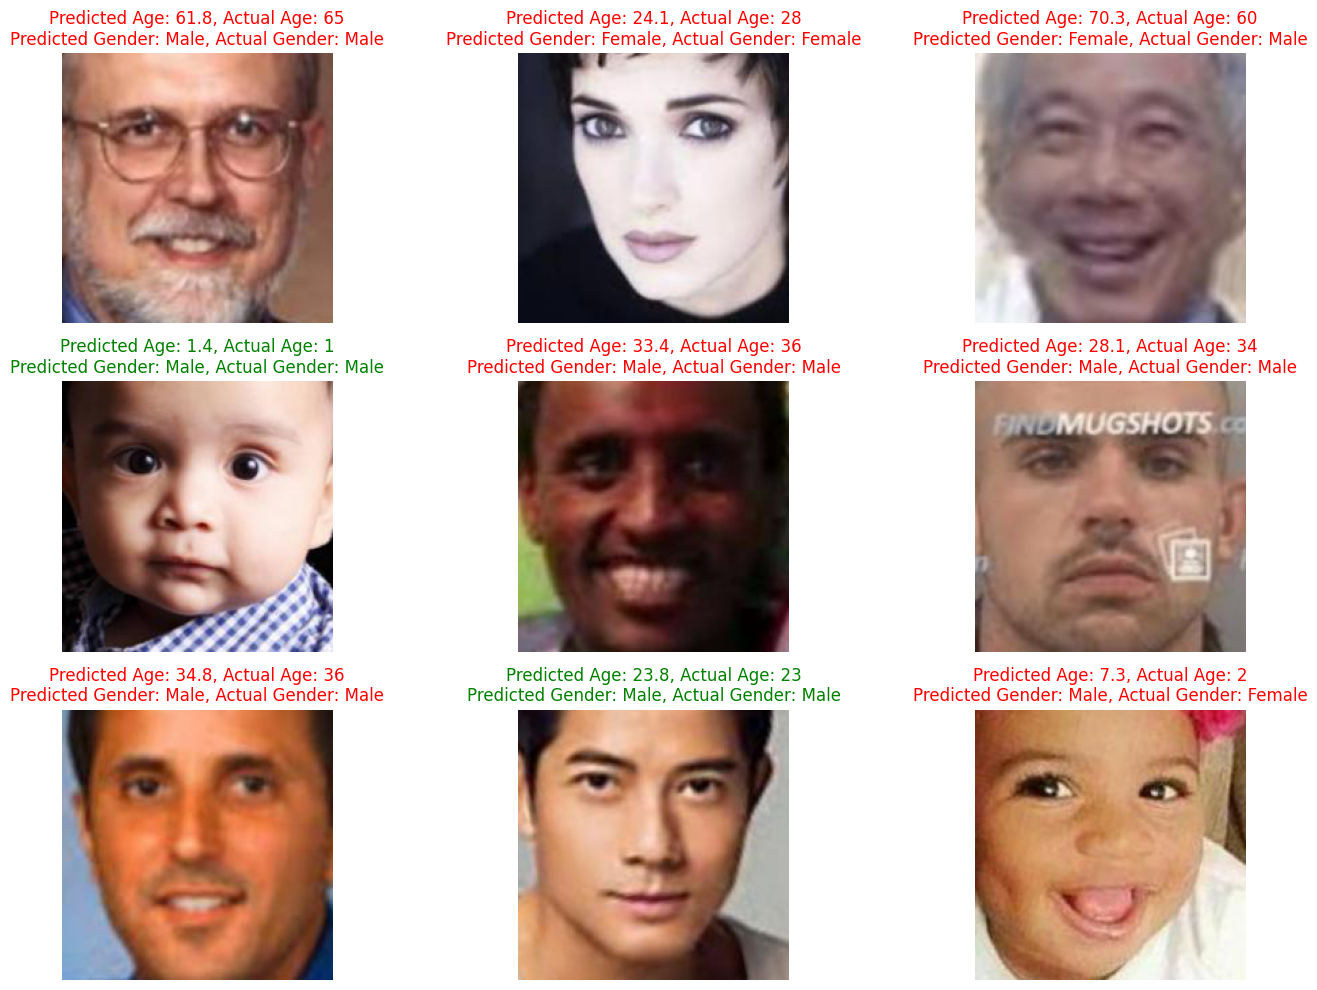

In [31]:
data_folder = 'data/UTKFace'
num_images = 9

all_files = os.listdir(data_folder)
valid_extensions = ('.jpg', '.jpeg', '.png', '.gif')
image_files = [f for f in all_files if f.lower().endswith(valid_extensions)]

random_image_files = random.choices(image_files, k=num_images)
random_image_paths = [os.path.join(data_folder, f) for f in random_image_files]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, image_path in enumerate(random_image_paths):
    predicted_age, predicted_gender, image = make_prediction(image_path, device)
    
    filename = os.path.basename(image_path)
    parts = filename.split('_')
    actual_age = int(parts[0])
    actual_gender = int(parts[1])  # 0 or 1
    
    age_correct = (int(predicted_age) == actual_age)
    gender_correct = (predicted_gender == actual_gender)
    all_correct = age_correct and gender_correct

    title_color = 'green' if all_correct else 'red'
    
    predicted_gender_label = gender_labels[predicted_gender]
    actual_gender_label = gender_labels[actual_gender]
    
    title_text = (
        f"Predicted Age: {predicted_age:.1f}, Actual Age: {actual_age}\n"
        f"Predicted Gender: {predicted_gender_label}, Actual Gender: {actual_gender_label}"
    )
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(title_text, color=title_color)

plt.tight_layout()
plt.show()